In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/preprocessed-dallas-public-safety/filtered_data_3.csv


In [2]:
import numpy as np
import pandas as pd

In [3]:
df = pd.read_csv('/kaggle/input/preprocessed-dallas-public-safety/filtered_data_3.csv')

In [4]:
# Group by 'Day1 of the Week' and calculate the total incident count for each day
day_counts = df.groupby('Day1 of the Week').size().reset_index(name='IncidentCount')

# Calculate the total number of incidents in the dataset
total_incidents = day_counts['IncidentCount'].sum()

# Calculate the percentage for each day and round to 2 decimal places
day_counts['Percentage'] = round((day_counts['IncidentCount'] / total_incidents) * 100, 2)

# Sort the day counts dictionary by percentage in descending order
sorted_day_incident_dict = dict(sorted(day_counts[['Day1 of the Week', 'Percentage']].values, key=lambda x: x[1], reverse=True))

# Create a DataFrame from the sorted dictionary
table_df = pd.DataFrame(sorted_day_incident_dict.items(), columns=['Day1 of the Week', 'Percentage'])

# Merge the 'Percentage' column from 'table_df' into the original 'df' and rename it
df = df.merge(table_df, on='Day1 of the Week', how='left').rename(columns={'Percentage': 'WeekDay-Percentage'})

# Print the updated DataFrame
print(df)

         Zip Code Day1 of the Week Time1 of Occurrence       Time Bin  \
0         75231.0              Tue               20:00          Night   
1         75240.0              Fri               12:00      Afternoon   
2         75215.0              Mon               12:00      Afternoon   
3         75209.0              Thu               01:38  Early Morning   
4         75208.0              Mon               17:30      Afternoon   
...           ...              ...                 ...            ...   
1127417   75205.0              Sat               10:45        Morning   
1127418   75204.0              Mon               19:00          Night   
1127419   75225.0              Sat               17:45      Afternoon   
1127420   75228.0              Tue               22:30          Night   
1127421   75238.0              Tue               12:30      Afternoon   

              Division  Sector  Zip-Time-Percentage  Zipcode-Day-Percentage  \
0            NORTHEAST   210.0              

In [5]:
# Define time bins
time_bins = {
    'Night': ('18:00', '23:59'),
    'Early Morning': ('00:00', '05:59'),
    'Morning': ('06:00', '11:59'),
    'Afternoon': ('12:00', '17:59')
}

# Create a function to assign time bins
def assign_time_bin(time):
    for bin_label, (start_time, end_time) in time_bins.items():
        if start_time <= time <= end_time:
            return bin_label
    return 'Unknown'

# Assign time bins to each row in the DataFrame
df['Time Bin'] = df['Time1 of Occurrence'].apply(assign_time_bin)

In [6]:
# Calculate the total incident count for each Time Bin
timebin_counts = df.groupby('Time Bin').size().reset_index(name='IncidentCount')

# Calculate the total number of incidents in the dataset
total_incidents = timebin_counts['IncidentCount'].sum()

# Calculate the percentage for each Time Bin and round to 2 decimal places
timebin_counts['Percentage'] = (timebin_counts['IncidentCount'] / total_incidents * 100).round(2)

# Sort the Time Bin percentages in descending order and create a DataFrame
table_df = (timebin_counts.sort_values(by='Percentage', ascending=False)
                        .reset_index(drop=True)
                        .rename(columns={'Time Bin': 'Time Bin', 'Percentage': 'TimeBin-Percentage'}))

# Merge the 'TimeBin-Percentage' column from 'table_df' into the original 'df'
df = df.merge(table_df[['Time Bin', 'TimeBin-Percentage']], on='Time Bin', how='left')

# Print the updated DataFrame to verify
print(df)

         Zip Code Day1 of the Week Time1 of Occurrence       Time Bin  \
0         75231.0              Tue               20:00          Night   
1         75240.0              Fri               12:00      Afternoon   
2         75215.0              Mon               12:00      Afternoon   
3         75209.0              Thu               01:38  Early Morning   
4         75208.0              Mon               17:30      Afternoon   
...           ...              ...                 ...            ...   
1127417   75205.0              Sat               10:45        Morning   
1127418   75204.0              Mon               19:00          Night   
1127419   75225.0              Sat               17:45      Afternoon   
1127420   75228.0              Tue               22:30          Night   
1127421   75238.0              Tue               12:30      Afternoon   

              Division  Sector  Zip-Time-Percentage  Zipcode-Day-Percentage  \
0            NORTHEAST   210.0              

In [7]:
df['Zipcode-Percentage'].fillna(0, inplace=True)

In [8]:
# Define the weights for each component
weight_zipcode = 0.3
weight_incident = 0.3
weight_weekday = 0.2
weight_timebin = 0.2

# Calculate the individual components
zipcode_component = df['Zipcode-Percentage'] * weight_zipcode
incident_component = df['Incident_Score'] * weight_incident
weekday_component = df['WeekDay-Percentage'] * weight_weekday
timebin_component = df['TimeBin-Percentage'] * weight_timebin

# Calculate the 'Proxy Safety Score' by summing the components
df['Proxy Safety Score'] = zipcode_component + incident_component + weekday_component + timebin_component


In [9]:
df.to_csv('/kaggle/working/weighted_safety_scores.csv', index=False)


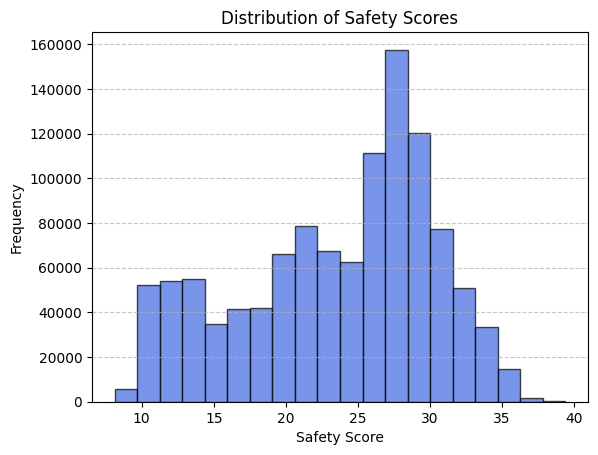

In [10]:
import matplotlib.pyplot as plt

# Define the data you want to visualize
data = df['Proxy Safety Score']

# Define the number of bins for the histogram
bins = 20

# Choose colors for the bars and edges
bar_color = 'royalblue'
edge_color = 'black'

# Set the transparency level for the bars
alpha = 0.7

# Create a histogram to visualize the data distribution
plt.hist(data, bins=bins, color=bar_color, edgecolor=edge_color, alpha=alpha)

# Add labels to the X and Y axes
plt.xlabel('Safety Score')
plt.ylabel('Frequency')

# Set a title for the plot
plt.title('Distribution of Safety Scores')

# Add grid lines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

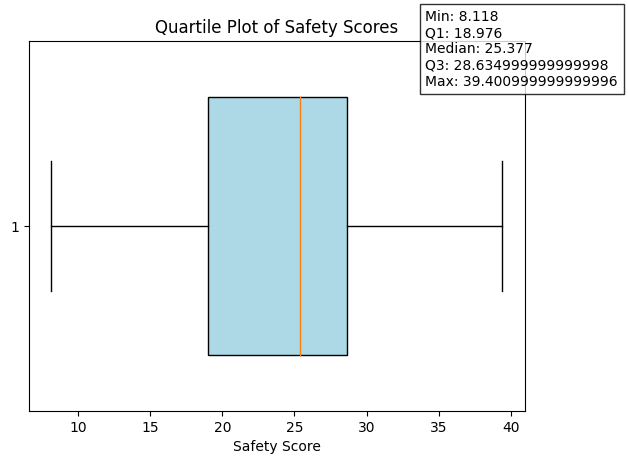

In [11]:
# Define the data for the box plot
data = df['Proxy Safety Score']

# Create a box plot with customized details
plt.boxplot(data, vert=False, widths=0.7, patch_artist=True, boxprops={'facecolor': 'lightblue', 'edgecolor': 'black'})

# Add labels to the X and Y axes
plt.xlabel('Safety Score')
plt.title('Quartile Plot of Safety Scores')

# Display quartile statistics as text
quartile_stats = [f'Min: {data.min()}', f'Q1: {data.quantile(0.25)}', f'Median: {data.median()}', f'Q3: {data.quantile(0.75)}', f'Max: {data.max()}']
plt.annotate('\n'.join(quartile_stats), xy=(0.8, 0.88), xycoords='axes fraction', fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

# Show the plot
plt.show()